<a href="https://colab.research.google.com/github/zwimpee/cursivetransformer/blob/main/cursivetransformer_mech_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup

!pip install git+https://github.com/callummcdougall/CircuitsVis.git#subdirectory=python
!pip install transformer_lens
!pip install gradio
!pip install wandb
!pip install einops
!pip install matplotlib
!pip install datasets

# Clone the cursivetransformer repository and install its requirements
!rm -rf cursivetransformer && git clone https://github.com/zwimpee/cursivetransformer.git
!pip install -r cursivetransformer/requirements.txt

  Cloning https://github.com/callummcdougall/CircuitsVis.git to /tmp/pip-req-build-rsqjz7ei
  Running command git clone --filter=blob:none --quiet https://github.com/callummcdougall/CircuitsVis.git /tmp/pip-req-build-rsqjz7ei
  Resolved https://github.com/callummcdougall/CircuitsVis.git to commit 1e6129d08cae7af9242d9ab5d3ed322dd44b4dd3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for circuitsvis: filename=circuitsvis-0.0.0-py3-none-any.whl size=6172334 sha256=59415c32edc93016c6c42f3b4833706a3be43b700e7573be5495cc7c0ec5f306
  Stored in directory: /tmp/pip-ephem-wheel-cache-f_t79nl_/wheels/86/be/ad/78078aba9344d200aad61b63d35cdaecdec160212f039eed74
Successfully built circuitsvis
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.4.0
    Uninstalling importlib_metadata-8.4.0:
      Successfully uninstalled importlib_metadata-8.4.0
ERROR: 

In [2]:
import pandas as pd
import os
import sys; sys.path.append('/content/cursivetransformer');
import copy
import types
from typing import List, Callable, Dict, Optional, Union, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import circuitsvis as cv
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from jaxtyping import Float, Int

from cursivetransformer.model import get_all_args, get_checkpoint, get_latest_checkpoint_artifact
from cursivetransformer.data import create_datasets, offsets_to_strokes, strokes_to_offsets
from cursivetransformer.sample import generate, generate_n_words, plot_strokes
from cursivetransformer.mech_interp import (
    HookedCursiveTransformer,
    HookedCursiveTransformerConfig,
    convert_cursivetransformer_model_config,
    visualize_attention
)

import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import ActivationCache

torch.set_grad_enabled(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
args = get_all_args(False)
args.sample_only = True
args.load_from_run_id = '6le6tujz'
args.wandb_entity = 'sam-greydanus'
args.dataset_name = 'bigbank'
args.wandb_run_name = 'cursivetransformer_dictionary_learning'

torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

train_dataset, test_dataset = create_datasets(args)

args.block_size = train_dataset.get_stroke_seq_length()
args.context_block_size = train_dataset.get_text_seq_length()
args.vocab_size = train_dataset.get_vocab_size()
args.context_vocab_size = train_dataset.get_char_vocab_size()

Trying to load dataset file from /content/cursivetransformer/data/bigbank.json.zip
Succeeded in loading the bigbank dataset; contains 1900 items.
For a dataset of 1805 examples we can generate 440811596555 combinations of 4 examples.
Generating 497000 4-word examples.
For a dataset of 95 examples we can generate 3183545 combinations of 4 examples.
Generating 3000 4-word examples.
Number of examples in the train dataset: 497000
Number of examples in the test dataset: 3000
Max token sequence length: 1000
Number of unique characters in the ascii vocabulary: 71
Ascii vocabulary:
	" enaitoshrdx.vpukbgfcymzw1lqj804I92637OTAS5N)EHR"'(BCQLMWYU,ZF!DXV?KPGJ"
Split up the dataset into 497000 training examples and 3000 test examples


# Load the model (original architecture)

In [5]:
model, _, _, _, _ = get_checkpoint(args)

Number of Transformer parameters: 368064
Model #params: 397184
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


# Generate some example handwritten text

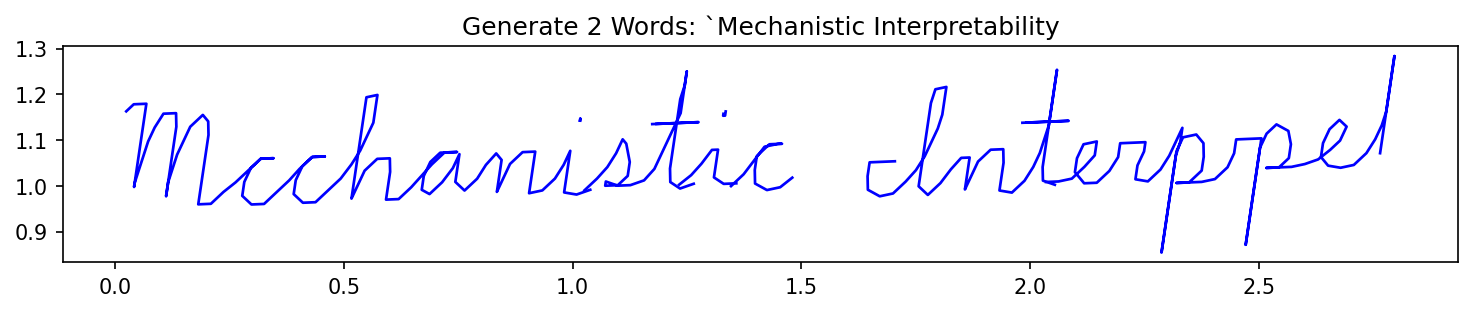

In [14]:
# - [x] TODO: Generate some samples
stroke_samp = generate_n_words(model, test_dataset, "Mechanistic Interpretability", model_device='cuda', n_words=2)
_ = plot_strokes(stroke_samp, "Generate 2 Words: `Mechanistic Interpretability`")

# Load model into HookedCursiveTransformer

In [4]:
cfg = convert_cursivetransformer_model_config(args)
model = HookedCursiveTransformer.from_pretrained("cursivetransformer", cfg)

Loading pretrained model cursivetransformer
Finding latest checkpoint for W&B run id 6le6tujz
  model:best_checkpoint:v70
  model:best_checkpoint:v71
  model:best_checkpoint:v72
  model:best_checkpoint:v73
  model:best_checkpoint:v74
  model:best_checkpoint:v75
  model:best_checkpoint:v76
  model:best_checkpoint:v77
  model:best_checkpoint:v78
  model:best_checkpoint:v79
  model:best_checkpoint:v80
  model:best_checkpoint:v81
  model:best_checkpoint:v82
  model:best_checkpoint:v83
  model:best_checkpoint:v84
  model:best_checkpoint:v85
  model:best_checkpoint:v86
  model:best_checkpoint:v87
  model:best_checkpoint:v88
  model:best_checkpoint:v89
  wandb-history:run-6le6tujz-history:v4
Selected:  model:best_checkpoint:v89


wandb:   1 of 1 files downloaded.  


Successfully loaded pretrained model cursivetransformer


# Induction Circuit Investigation and Analysis





In [ ]:
def generate_repeated_stroke_tokens(
    model,
    seq_len: int,
    n_repeats: int,
    batch_size: int = 1
) -> Int[torch.Tensor, "batch_size full_seq_len"]:
    """
    Generates a sequence of repeated stroke tokens, alternating between θ and r tokens.

    Args:
        model: The model instance.
        seq_len: Number of (θ, r) pairs in the initial sequence.
        n_repeats: Number of times to repeat the sequence.
        batch_size: Batch size.

    Returns:
        rep_tokens: Tensor of shape [batch_size, n_repeats * 2 * seq_len]
    """
    device = model.cfg.device
    feature_sizes = test_dataset.feature_sizes  # [size_r_bins, size_theta_bins]
    cumulative_sizes = test_dataset.cumulative_sizes  # cumulative indices for token types

    # Get valid indices for θ and r tokens
    theta_token_indices = torch.arange(
        cumulative_sizes[1],
        cumulative_sizes[2],
        device=device
    )
    r_token_indices = torch.arange(
        cumulative_sizes[0],
        cumulative_sizes[1],
        device=device
    )

    # Generate random θ and r tokens
    random_theta_tokens = theta_token_indices[
        torch.randint(
            low=0,
            high=feature_sizes[1],
            size=(batch_size, seq_len),
            device=device
        )
    ]
    random_r_tokens = r_token_indices[
        torch.randint(
            low=0,
            high=feature_sizes[0],
            size=(batch_size, seq_len),
            device=device
        )
    ]

    # Alternate between θ and r tokens
    stroke_tokens_half = torch.zeros(batch_size, seq_len * 2, dtype=torch.long, device=device)
    stroke_tokens_half[:, 0::2] = random_theta_tokens
    stroke_tokens_half[:, 1::2] = random_r_tokens

    # Repeat the sequence
    rep_tokens = stroke_tokens_half.repeat(1, n_repeats)

    return rep_tokens

def generate_random_ascii_context(
    model,
    batch_size: int = 1
) -> Int[torch.Tensor, "batch_size context_seq_len"]:
    """
    Generates a random ASCII context sequence.

    Args:
        model: The model instance.
        batch_size: Batch size.

    Returns:
        context_tokens: Tensor of shape [batch_size, context_seq_len]
    """
    device = model.cfg.device
    context_seq_len = model.cfg.context_block_size
    context_vocab_size = model.cfg.context_vocab_size

    context_tokens = torch.randint(
        low=0,
        high=context_vocab_size - 1,  # Exclude PAD token
        size=(batch_size, context_seq_len),
        dtype=torch.long,
        device=device
    )

    return context_tokens

In [ ]:
def run_and_cache_model_repeated_tokens(
    model,
    rep_tokens: torch.Tensor,
    context_tokens: torch.Tensor
) -> Tuple[torch.Tensor, torch.Tensor, ActivationCache]:
    """
    Runs the model on repeated tokens and caches activations.

    Args:
        model: The model instance.
        rep_tokens: Input stroke tokens of shape [batch_size, seq_len]
        context_tokens: Input context tokens of shape [batch_size, context_seq_len]

    Returns:
        logits: Model output logits.
        cache: Activation cache.
    """
    # Shift inputs to create targets
    inputs = rep_tokens[:, :-1]
    targets = rep_tokens[:, 1:]

    # Run model with cache
    logits, cache = model.run_with_cache(
        tokens=inputs,
        context=context_tokens,
        targets=targets,
        return_type="both"
    )

    return logits, targets, cache

In [ ]:
# - [ ] TODO: use test_dataset.cumulative_sizes to get token index ranges for r and theta
def sanity_check_token_pairs(rep_tokens: torch.Tensor):
    """
    Performs a sanity check to ensure that token pairs are correctly formed.

    Args:
        rep_tokens: Input stroke tokens of shape [batch_size, seq_len]
    """
    batch_size, seq_len = rep_tokens.shape
    assert seq_len % 2 == 0, "Sequence length should be even to form (θ, r) pairs."

    token_pairs = rep_tokens.view(batch_size, seq_len // 2, 2)  # Shape: [batch_size, seq_len_pairs, 2]
    for pair in token_pairs[0]:
        theta, r = pair.tolist()
        # Add any specific checks for theta and r validity if applicable
        # For example, ensure that theta and r are within expected ranges
        # Here, we'll simply print a few pairs for manual inspection
    print("Sample token pairs:", token_pairs[0][:5].tolist())

In [ ]:
def verify_attention_summation(cache: ActivationCache, layer: int, head: int, attn_type: str = 'self'):
    """
    Verifies that attention weights sum to 1 across key positions for each query.

    Args:
        cache: Activation cache.
        layer: Layer index.
        head: Head index.
        attn_type: 'self' or 'cross' to specify attention type.
    """
    with torch.no_grad():
        if attn_type == 'self':
            attn = cache[f'blocks.{layer}.attn.hook_pattern'][0, head]
        elif attn_type == 'cross':
            attn = cache[f'blocks.{layer}.cross_attn.hook_pattern'][0, head]
        else:
            raise ValueError("attn_type must be 'self' or 'cross'")

    attn_sum = attn.sum(dim=-1)
    if not torch.allclose(attn_sum, torch.ones_like(attn_sum), atol=1e-5):
        print(f"Attention weights do not sum to 1 for Layer {layer}, Head {head} ({attn_type}-Attention).")
    else:
        print(f"Attention weights verified for Layer {layer}, Head {head} ({attn_type}-Attention).")

In [ ]:
def compute_induction_scores(
    rep_tokens: torch.Tensor,
    cache: ActivationCache,
    model: HookedCursiveTransformer
) -> torch.Tensor:
    """
    Computes induction scores for all attention heads.

    Args:
        rep_tokens: Input tokens of shape [batch_size, seq_len]
        cache: Activation cache containing attention patterns.
        model: The transformer model.

    Returns:
        induction_scores: Tensor of shape [num_layers, num_heads]
    """
    num_layers = model.cfg.n_layers
    num_heads = model.cfg.n_heads
    induction_scores = torch.zeros(num_layers, num_heads, device=model.cfg.device)

    batch_size, seq_len = rep_tokens.shape

    tokens = rep_tokens[:, :-1]  # Exclude last token
    targets = rep_tokens[:, 1:]  # Exclude first token

    for layer in range(num_layers):
        attention = cache["pattern", layer]  # Shape: [batch_size, num_heads, seq_len - 1, seq_len - 1]

        for head in range(num_heads):
            # Extract attention weights for this head
            attn_weights = attention[:, head]  # Shape: [batch_size, seq_len - 1, seq_len - 1]

            # Initialize induction score for this head
            score_sum = 0.0

            for b in range(batch_size):
                for t in range(1, seq_len - 1):
                    # Current token and previous tokens
                    current_token = tokens[b, t]
                    previous_tokens = tokens[b, :t]

                    # Find positions where previous_tokens == current_token
                    matching_positions = (previous_tokens == current_token).nonzero(as_tuple=True)[0]

                    # For each matching position, check if the next token matches the target
                    for pos in matching_positions:
                        if targets[b, pos] == targets[b, t]:
                            # Accumulate attention weight
                            score_sum += attn_weights[b, t, pos].item()

            # Normalize the score
            induction_scores[layer, head] = score_sum / (batch_size * (seq_len - 2))

    return induction_scores

In [ ]:
def compute_cross_attention_induction_scores(
    model,
    context_tokens: torch.Tensor,
    cache: ActivationCache
) -> torch.Tensor:
    """
    Computes induction-like scores for cross-attention heads.

    Args:
        model: The model instance.
        context_tokens: Context tokens of shape [batch_size, context_seq_len]
        cache: Activation cache.

    Returns:
        cross_induction_scores: Tensor of shape [num_layers, num_heads]
    """
    num_layers = model.cfg.n_layers
    num_heads = model.cfg.n_heads
    cross_induction_scores = torch.zeros(num_layers, num_heads, device=model.cfg.device)

    batch_size, context_seq_len = context_tokens.shape

    for layer in range(num_layers):
        attn_patterns = cache["pattern", layer, "cross_attn"]  # Need to access cross-attention patterns
        for head in range(num_heads):
            attn = attn_patterns[0, head]  # Shape: [stroke_seq_len, context_seq_len]
            # For this example, we might need more specific analysis based on the use case
            # Placeholder for cross-attention induction score computation
            cross_induction_scores[layer, head] = attn.mean().item()
    return cross_induction_scores

In [ ]:
def plot_induction_scores(induction_scores: torch.Tensor):
    """
    Plots a heatmap of induction scores with categorical annotations.

    Args:
        induction_scores: Tensor of shape [num_layers, num_heads]
    """
    plt.figure(figsize=(12, 6))
    induction_scores_np = induction_scores.cpu().numpy()

    # Define thresholds
    high_threshold = 0.05
    medium_threshold = 0.02

    # Create a mask for categories
    categories = np.empty_like(induction_scores_np, dtype=str)
    categories[induction_scores_np > high_threshold] = 'High'
    categories[(induction_scores_np <= high_threshold) & (induction_scores_np > medium_threshold)] = 'Moderate'
    categories[induction_scores_np <= medium_threshold] = 'Low'

    # Plot heatmap
    sns.heatmap(
        induction_scores_np,
        annot=induction_scores_np,
        fmt=".3f",
        cmap="YlGnBu",
        xticklabels=[f"H{h}" for h in range(induction_scores.shape[1])],
        yticklabels=[f"L{l}" for l in range(induction_scores.shape[0])],
        cbar_kws={'label': 'Induction Score'}
    )

    # Overlay categories
    for i in range(induction_scores_np.shape[0]):
        for j in range(induction_scores_np.shape[1]):
            plt.text(j + 0.5, i + 0.5, categories[i, j],
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='red' if categories[i, j] == 'High' else
                            'orange' if categories[i, j] == 'Moderate' else
                            'black',
                     fontsize=8)

    plt.title("Induction Scores per Head")
    plt.xlabel("Heads")
    plt.ylabel("Layers")
    plt.show()

In [ ]:
def plot_head_attention_pattern(
    cache: ActivationCache,
    layer: int,
    head: int,
    seq_len: int,
    attn_type: str = 'self'
):
    """
    Plots the attention pattern of a specific head with enhanced clarity.

    Args:
        cache: Activation cache.
        layer: Layer index.
        head: Head index.
        seq_len: Total sequence length.
        attn_type: 'self' or 'cross' to specify attention type.
    """
    with torch.no_grad():
        if attn_type == 'self':
            attn = cache[f'blocks.{layer}.attn.hook_pattern'][0, head].cpu().numpy()
        elif attn_type == 'cross':
            attn = cache[f'blocks.{layer}.cross_attn.hook_pattern'][0, head].cpu().numpy()
        else:
            raise ValueError("attn_type must be 'self' or 'cross'")

    plt.figure(figsize=(10, 8))
    sns.heatmap(
        attn,
        cmap='viridis',
        cbar=True,
        square=True,
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f"Attention Pattern - Layer {layer}, Head {head} ({attn_type}-Attention)")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.tight_layout()
    plt.show()

In [ ]:
def create_induction_summary(induction_scores: torch.Tensor, threshold_high=0.05, threshold_medium=0.02):
    """
    Creates a summary table of induction scores with categories.

    Args:
        induction_scores: Tensor of shape [num_layers, num_heads]
        threshold_high: Threshold for high induction score
        threshold_medium: Threshold for moderate induction score

    Returns:
        df_summary: Pandas DataFrame with Layer, Head, Score, and Category
    """
    num_layers, num_heads = induction_scores.shape
    data = []
    for layer in range(num_layers):
        for head in range(num_heads):
            score = induction_scores[layer, head].item()
            if score > threshold_high:
                category = 'High'
            elif score > threshold_medium:
                category = 'Moderate'
            else:
                category = 'Low'
            data.append({'Layer': layer, 'Head': head, 'Score': score, 'Category': category})
    df_summary = pd.DataFrame(data)
    return df_summary

In [ ]:
def ablate_heads(
    model: HookedCursiveTransformer,
    head_list: List[Tuple[int, int]],
    rep_tokens: torch.Tensor,
    context_tokens: Optional[torch.Tensor] = None
) -> torch.Tensor:
    from transformer_lens.hook_points import HookPoint
    from functools import partial

    # Define hook function with debugging statements
    def zero_out_head_output(value, hook: HookPoint, head_idx: int):
        # value shape: [batch_size, seq_len, n_heads, d_head]
        before_ablation = value[:, :, head_idx, :].clone()
        value[:, :, head_idx, :] = 0.0
        after_ablation = value[:, :, head_idx, :]
        change = torch.sum(torch.abs(before_ablation - after_ablation)).item()
        print(f"Ablating head {head_idx} in {hook.name}, total change: {change}")
        return value

    # Set up hooks
    ablation_hooks = []
    for layer_idx, head_idx in head_list:
        hook_name = f"blocks.{layer_idx}.attn.hook_result"
        hook_fn = partial(zero_out_head_output, head_idx=head_idx)
        ablation_hooks.append((hook_name, hook_fn))

    # Run the model with ablation hooks
    inputs = rep_tokens[:, :-1]
    logits = model.run_with_hooks(
        inputs,
        context=context_tokens,
        return_type="logits",
        fwd_hooks=ablation_hooks
    )

    return logits

In [ ]:
def compute_loss_on_induction_positions(
    logits, targets, induction_positions
):
    """
    Computes cross-entropy loss only on the specified positions.

    Args:
        logits: Model logits of shape [batch_size, seq_len, vocab_size]
        targets: Target tokens of shape [batch_size, seq_len]
        induction_positions: List of tensors indicating positions to include in loss

    Returns:
        loss: Scalar tensor representing the loss on the specified positions
    """
    import torch.nn.functional as F

    batch_size, seq_len, vocab_size = logits.shape
    logits_flat = logits.reshape(-1, vocab_size)
    targets_flat = targets.reshape(-1)

    # Create mask for induction positions
    mask = torch.zeros(batch_size * seq_len, dtype=torch.bool, device=logits.device)
    for b in range(batch_size):
        indices = induction_positions[b] + b * seq_len
        mask[indices] = True

    # Apply the mask
    logits_masked = logits_flat[mask]
    targets_masked = targets_flat[mask]

    # Compute loss
    loss = F.cross_entropy(logits_masked, targets_masked)
    return loss

In [ ]:
def get_induction_positions(rep_tokens, pattern_length, n_repeats):
    batch_size, seq_len = rep_tokens.shape
    induction_positions = []

    for b in range(batch_size):
        positions = []
        # Assuming equal pattern repeats
        for i in range(1, n_repeats):
            start = i * pattern_length * 2  # Times 2 because each pattern token is two tokens long (theta and r)
            end = (i + 1) * pattern_length * 2
            positions.extend(range(start, end))
        induction_positions.append(torch.tensor(positions, dtype=torch.long, device=rep_tokens.device))
    return induction_positions

In [ ]:
def activation_patching(
    model: HookedCursiveTransformer,
    src_tokens: torch.Tensor,
    dst_tokens: torch.Tensor,
    layer: int,
    head: int,
    context_tokens: Optional[torch.Tensor] = None
) -> torch.Tensor:
    """
    Patches activations from src_tokens into dst_tokens at a specific layer and head.

    Args:
        model: The transformer model.
        src_tokens: Source input tokens.
        dst_tokens: Destination input tokens.
        layer: Layer index.
        head: Head index.
        context_tokens: Optional context tokens.

    Returns:
        logits: Model logits with patched activations.
    """
    from transformer_lens.hook_points import HookPoint

    def replace_head_activation(dst_value, hook: HookPoint):
        # Run the model on src_tokens to get the source head activation
        src_cache = {}
        def save_src_activation(value, hook):
            src_cache["value"] = value.detach()
            return value

        # Run src_tokens to get the source activation
        model.run_with_hooks(
            src_tokens,
            context=context_tokens,
            fwd_hooks=[(hook.name, save_src_activation)]
        )

        # Replace the destination activation with source activation for the specified head
        dst_value[:, :, head, :] = src_cache["value"][:, :, head, :]
        return dst_value

    # Run the model with activation patching
    inputs = dst_tokens[:, :-1]
    logits = model.run_with_hooks(
        inputs,
        context=context_tokens,
        return_type="logits",
        fwd_hooks=[(f"v{layer}", replace_head_activation)]
    )

    return logits

In [ ]:
seq_len = 50  # Number of (θ, r) pairs in the initial sequence
n_repeats = 2  # Number of repetitions
batch_size = 1

# Generate repeated stroke tokens and random ASCII context
rep_tokens = generate_repeated_stroke_tokens(model, seq_len, n_repeats, batch_size)
context_tokens = generate_random_ascii_context(model, batch_size)

# Run the model and cache activations
model = model.to(device)
logits, targets, cache = run_and_cache_model_repeated_tokens(model, rep_tokens.to(device), context_tokens.to(device))

# sanity_check_token_pairs(rep_tokens)
# verify_attention_summation(cache, layer=2, head=3, attn_type='self')

induction_scores = compute_induction_scores(model, rep_tokens, cache)
plot_induction_scores(induction_scores)

In [ ]:
# Identify top N heads with highest induction scores
N = 5
induction_scores_flat = induction_scores.view(-1)
top_scores, top_indices = torch.topk(induction_scores_flat, N)
num_heads = model.cfg.n_heads

print(f"Top {N} Induction Heads:")
for rank, (score, idx) in enumerate(zip(top_scores, top_indices), start=1):
    layer = idx // num_heads
    head = idx % num_heads
    print(f"{rank}. Layer {layer}, Head {head}, Induction Score: {score:.4f}")
    # Plot attention pattern
    plot_head_attention_pattern(cache, layer, head, seq_len * n_repeats * 2, attn_type='self')

In [ ]:
# Create and display summary table
df_induction = create_induction_summary(induction_scores)
display(df_induction.sort_values(by='Score', ascending=False))

In [ ]:
# Original logits from previous model run
original_logits = logits[0]

original_loss = F.cross_entropy(
    original_logits.reshape(-1, original_logits.size(-1)),
    targets.reshape(-1)
)
print(f"Original Loss: {original_loss.item():.4f}")

In [ ]:
# Example head_list with attention types
heads_to_ablate = [
    (layer_idx, head_idx, 'self')  # or 'cross'
    for layer_idx in range(model.cfg.n_layers)
    for head_idx in range(model.cfg.n_heads)
    if induction_scores[layer_idx, head_idx] > threshold
]

# Run ablation with corrected hook names
ablated_logits = ablate_heads(model, heads_to_ablate, rep_tokens, context_tokens)

# Evaluate performance
import torch.nn.functional as F

targets = rep_tokens[:, 1:]

ablated_loss = F.cross_entropy(
    ablated_logits.reshape(-1, ablated_logits.size(-1)),
    targets.reshape(-1)
)
print(f"Ablated Loss: {ablated_loss.item():.4f}")

In [ ]:
# Parameters used to generate rep_tokens
pattern_length = 5  # Length of the repeating pattern
n_repeats = 3       # Number of repeats

# Get induction positions
induction_positions = get_induction_positions(rep_tokens, pattern_length, n_repeats)

# Compute loss on induction positions
original_loss = compute_loss_on_induction_positions(logits, targets, induction_positions)
ablated_loss = compute_loss_on_induction_positions(ablated_logits, targets, induction_positions)

print(f"Original Loss on Induction Positions: {original_loss.item():.4f}")
print(f"Ablated Loss on Induction Positions: {ablated_loss.item():.4f}")